# QF 627 Extras - Financial Analytics
## Lesson 6 | Regression Discontinuity

> Hi, Team üëã Thank you for opening the script üôÇ

> Tonight we‚Äôll dive into one of the most powerful tools in the causal inference toolbox‚ÄîRegression Discontinuity (RD).

> This method shines when randomization isn‚Äôt possible, but a sharp threshold or cutoff gives us a natural experiment. It allows us to estimate causal effects in a rigorous way, leveraging the idea that units just above and below a cutoff are nearly identical‚Äîexcept for the treatment.

> We‚Äôll learn about how RD designs work, when to use them, what assumptions they rely on, and how to interpret their results. By the end of this session, you'll not only understand the mechanics but also how to critically assess an RD study and maybe even run one yourself.

> Let‚Äôs get started.

## DEPENDENCIES

In [1]:
# Load libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime
import re

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

# Set print options

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Define our customized timer function

def countdown(Time):
    
    while Time:
        minutes, seconds = divmod(Time, 60)
        timer = "{:02d}:{:02d}".format(minutes, seconds)
        
        print(timer, end = "\r")
        time.sleep(1)
        Time -= 1
        
    print("Let us solve the problem above together :)")

## üëâ <a id = "top">Learning Pointers</a> üëà 

## [1. BIG PICTURE: Algorithmic Decision Making on Method of Causal Inference](#p1)

> ### <font color = red> Where do we stand? </font>

## [2. Regression Discontinuity Design](#p2)

> ### <font color = red> RDD </font>

## [3. What We Learned & What's Next](#p3)

> ### <font color = red> Revisiting Learning Pointers </font>

## <a id = "p1">1.</a>  <font color = "green"> BIG PICTURE: Algorithmic Decision Making on Method of Causal Inference </font>  [back to table of contents](#top)

> Thus far, we‚Äôve explored causal inference in situations where the gold standard‚Äîrandomized controlled trials‚Äîis not feasible. As you've seen, methods like matching and difference-in-differences can be powerful tools.

> However, it‚Äôs not enough to understand each method in isolation. To apply what you've learned in real-world settings, it's essential to know when to use which causal inference method.

> As always, I‚Äôd like to give you the big picture before diving into the details. Think of this as a <mark>gift function</mark>‚Äîan algorithmic decision aid to help you select the right causal inference method for a given scenario.

> As you'll see below, both matching and difference-in-differences require specific conditions to be met. Today, we'll introduce a third method‚Äîregression discontinuity‚Äîwhich, in many cases, relies on a relatively simple and realistic condition for causal identification.

In [2]:
def would_you_recommend_causal_inference_method():
    print("Welcome to the Causal Inference Recommender architected by Prof. Roh :)")
    print("Please answer to the following questions with either 'yes' or 'no'.\n")

    # Question 1. RCT Feasibility (from observation to intervention)
    can_randomized =\
    (
        input("Question 1: Can we RANDOMIZE the treatment assignment? (yes / no): ")
        .strip()
        .lower()
    )
    
    if can_randomized == "yes":
        print("\nRecommended Method: **RCTs (Randomized Controlled Trials)**")
        return

    # Question 2. Threshold for RDD
    has_threshold =\
    (input("Question 2: Is there a threshold that assigns treatment (e.g., cut-off) (yes / no): ?")
     .strip()
     .lower()
    )
    
    if has_threshold == "yes":
        print("\nRecommended Method: **RDD (Regression Discontinuity Design)")
        return

    # Question 3. Check for Panel (vs. Cross-sectional) or Time-Series Data
    has_panel_data =\
    (input("Question 3: Do we have panel (longitudinal) or repeated Cross-Sectional Data over Time? (yes / no): ")
     .strip()
     .lower()
    )
    
    if has_panel_data == "yes":
        # contingency

        # Question 4. Do we have single or multiple treated units
        single_treated =\
        (
         input("Question 4: Do you have ONLY ONE treated unit (e.g., one city, one district)? (yes / no): ")
            .strip()
            .lower()
        )
        
        if single_treated == "yes":
            
            parallel_trends =\
            (
                input("Question 5: Are we confident the 'parallel trends' assumption would hold if you used a DiD? (yes / no): ")
                .strip()
                .lower()
            )

            if parallel_trends == "yes":
                print("\nParallel trends might hold, but you still only have ONE TREATED UNIT...")
                print("\nRecommended Method: **Difference-in-Differences is fine.**"
                     )
            else:
                print("\nSince parallel trends are questionable and there's only ONE TREATED UNIT...")
                print("\nRecommended Method: **Synthetic Control**")
            return

        else: 
            parallel_trends = input("Question 5: Can we assume paraell trends with multiple treated units? (yes / no ): ").strip().lower()
            if parallel_trends == "yes":
                print("\nRecommended Method: **Difference-in-Differences (DiD) ** ")
                return
            else: 
                print("\nParallel trends are questionable for multiple treated units.")
                print("\nTeam, you should consider more advanced methods as follows:")
                print("\n - Matching along with DiD (to align pre-trends on a matched sample.")
                print("\n - Synthetic Control for subsets if feasible")
                print("\n - More advanced methods ... call Prof. Roh :)")
                return

    else: 
        print("\n Recommended Method: **Matching** (Propensity Scoring and Inverse Probability Weights (**IPW**).")
        return

## <a id = "p2">2.</a>  <font color = "green"> Regression Discontinuity Design </font>  [back to table of contents](#top)

### <mark>Illustrating Causal Inference with a Clear Regression Discontinuity Example</mark>

> Imagine you're in school and there's a special tutoring program available only for students who score below 60% on a particular test. If you get a 59%, you're eligible for tutoring, but if you get a 61%, you're not.

> Now, let's say we want to know if the tutoring program actually helps students improve their grades. One way to find this out is by looking at the students who scored just below 60% and those who scored just above 60%. They are very similar in their abilities since their scores are so close, but only the ones below 60% got the extra tutoring.

> If the students who scored 59% (and got tutoring) later perform much better than those who scored 61% (and didn't get tutoring), then we can reasonably infer that the tutoring had a significant positive effect.

> Regression Discontinuity Design (RDD) takes advantage of this "cutoff" or "threshold" (in our example, the 60% mark) to estimate the treatment effect. RDD assumes that just to the left and just to the right of this cutoff, students are pretty much the same in terms of their abilities, except for the treatment they receive. Therefore, any jump or discontinuity in performance at that threshold is attributed to the treatment (tutoring, in our example).

> Graphically, if you were to plot students' scores on the x-axis and their later performance on the y-axis, the point where the line "breaks" or "jumps" at the 60% mark shows the effect of the tutoring.

> One real application of RDD is looking at the effects of class size on student achievement. In some places, if the number of students in a grade exceeds a certain number, they split the grade into two smaller classes. So, students in a grade with just one student over the threshold end up in smaller classes than those in a grade with one student under the threshold. Researchers can then compare the performance of students just above and below this threshold to estimate the effect of class size on achievement.

### Define

> Does the pandemic (here, circuit breaker) affect people's searches on online learning platforms (i.e., Coursera) in Singapore?

- `B-hat` Question; Causal Inference; Econometric Question

In [3]:
# !pip install pytrends # Google Trends

In [4]:
from urllib3.util.retry import Retry
import urllib3

# Wrap Retry.__init__ so that method_whitelist is forwarded to allowed_methods
_orig_retry_init = Retry.__init__
def _patched_init(self, *args, method_whitelist=None, allowed_methods=None, **kwargs):
    if method_whitelist is not None and allowed_methods is None:
        allowed_methods = method_whitelist
    return _orig_retry_init(self, *args, allowed_methods=allowed_methods, **kwargs)

Retry.__init__ = _patched_init

### IMPORT

In [5]:
from pytrends.request import TrendReq

In [6]:
pytrends =\
(
    TrendReq(hl = "en-US", # iso-2c code
             tz = 360, # CST
             retries = 3
            )
)

In [7]:
# Parameters for Search Queries

# keywords
kw_list = ["Coursera"]

# timeframe
timeframe = "2020-01-01 2020-12-31" # Circuit Breaker April through June 2020

# geographical location
geo = "SG"

In [8]:
(
    pytrends
    .build_payload(kw_list,
                   timeframe = timeframe,
                   geo = geo)
)

In [9]:
import time
from requests.exceptions import RetryError

for attempt in range(5):
    try:
        DF =\
        (
            pytrends
            .interest_over_time()
        )
        break
    except RetryError as e:
        print(f"Attempt {attempt+1} got a 429. Backing off...")
        time.sleep(10 * (attempt + 1))  # exponential backoff: 10s, 20s, 30s, ...
else:
    raise RuntimeError("Still getting 429 after several retries.")

In [10]:
DF = DF[1: ]

In [11]:
DF

Coursera  isPartial
date                           
2020-01-05        33      False
2020-01-12        20      False
2020-01-19        31      False
2020-01-26        25      False
2020-02-02        25      False
2020-02-09        30      False
2020-02-16        34      False
2020-02-23        35      False
2020-03-01        39      False
2020-03-08        28      False
2020-03-15        39      False
2020-03-22        40      False
2020-03-29        48      False
2020-04-05        75      False
2020-04-12        82      False
2020-04-19        76      False
2020-04-26        83      False
2020-05-03        95      False
2020-05-10       100      False
2020-05-17        97      False
2020-05-24        97      False
2020-05-31        91      False
2020-06-07        81      False
2020-06-14        82      False
2020-06-21        70      False
2020-06-28        66      False
2020-07-05        59      False
2020-07-12        71      False
2020-07-19        62      False
2020-07-26        59      False
2020-08-02        59      False
2020-08-09        61      False
2020-08-16        50      False
2020-08-23        59      False
2020-08-30        58      False
2020-09-06        66      False
2020-09-13        62      False
2020-09-20        60      False
2020-09-27        55      False
2020-10-04        59      False
2020-10-11        49      False
2020-10-18        55      False
2020-10-25        48      False
2020-11-01        36      False
2020-11-08        33      False
2020-11-15        45      False
2020-11-22        44      False
2020-11-29        53      False
2020-12-06        56      False
2020-12-13        48      False
2020-12-20        45      False
2020-12-27        56      False

### WRANGLE

In [12]:
DF["Month"] =\
(
    DF
    .index
    .month
)

DF.head(3)

Coursera  isPartial  Month
date                                  
2020-01-05        33      False      1
2020-01-12        20      False      1
2020-01-19        31      False      1

In [13]:
DF =\
(
    DF
    .reset_index()
    .rename(columns = {"index": "date"}
           )
)

In [14]:
DF.head(3)

date  Coursera  isPartial  Month
0 2020-01-05        33      False      1
1 2020-01-12        20      False      1
2 2020-01-19        31      False      1

In [15]:
DF.dtypes

date         datetime64[ns]
Coursera              int64
isPartial              bool
Month                 int32
dtype: object

In [16]:
DF["date_numeric"] =\
(
    DF["date"]
    .view("int64") # encode of the date in numerical feature
)

In [17]:
DF.head(3)

date  Coursera  isPartial  Month         date_numeric
0 2020-01-05        33      False      1  1578182400000000000
1 2020-01-12        20      False      1  1578787200000000000
2 2020-01-19        31      False      1  1579392000000000000

In [18]:
DF["before_during_after"] =\
(
    pd
    .cut(
        DF["date_numeric"],
        bins = [pd.Timestamp("2020-01-01").value,
                pd.Timestamp("2020-03-31").value,
                pd.Timestamp("2020-06-30").value,
                pd.Timestamp("2021-01-01").value],
        labels = ["Before", "During", "After"],
        right = False
    )
)

In [19]:
DF["before_during_after"].unique()

['Before', 'During', 'After']
Categories (3, object): ['Before' < 'During' < 'After']

In [20]:
DF.head(3)

date  Coursera  isPartial  Month         date_numeric  \
0 2020-01-05        33      False      1  1578182400000000000   
1 2020-01-12        20      False      1  1578787200000000000   
2 2020-01-19        31      False      1  1579392000000000000   

  before_during_after  
0              Before  
1              Before  
2              Before

In [21]:
DF.tail(3)

date  Coursera  isPartial  Month         date_numeric  \
49 2020-12-13        48      False     12  1607817600000000000   
50 2020-12-20        45      False     12  1608422400000000000   
51 2020-12-27        56      False     12  1609027200000000000   

   before_during_after  
49               After  
50               After  
51               After

### VISUALIZE

In [22]:
# When nothing happened, there should be continuity in regression

from lets_plot import *
LetsPlot.setup_html()

In [23]:
DF.columns

Index(['date', 'Coursera', 'isPartial', 'Month', 'date_numeric',
       'before_during_after'],
      dtype='object')

In [24]:
line_chart =\
(
    ggplot(DF,
           aes(x = "date",
               y = "Coursera",
               group = "before_during_after"
               )
          )
    + geom_line(aes(color = "before_during_after")
               ) 
    + geom_point(aes(color = "before_during_after")
                 ) 
    + theme(legend_position = "top")
)

line_chart.show()

In [25]:
regression_chart =\
(
    ggplot(DF,
           aes(x = "date",
               y = "Coursera",
               group = "before_during_after"
               )
          )
    + geom_smooth(aes(color = "before_during_after")
                 )
    + geom_point(aes(color = "before_during_after")
                 ) 
    + theme(legend_position = "top")    
)

regression_chart.show()

In [26]:
plot_list = [line_chart, regression_chart]

In [27]:
gggrid([line_chart, regression_chart]
      )

    PROF. Roh's NOTE: 

    > I found that it would be helpful if I unpack the textbook portion of the RDD here a bit. I hope this helps for your full absorption of RDD.

### Analytics Contexts

> RDD is useful when a treatment, strategy, or policy is assigned based on a threshold value in a continuous variable. It compares the outcomes of observations just above and below the threshold to estimate the causal effect of the treatment.

> Sharp Regression Discontinuity Design (RDD)

$$ Y_i = \alpha + \tau D_i + \beta X_i + \epsilon_i $$


- $Y_i$ denotes the outcome of interest for observation \( i\)

- $D_i$ denotes a binary indicator for treatment assignment, equal to 1 if the assignment for observation is above the cutoff, and 0 otherwise.

- $\tau$ is the coefficient of interest, representing the causal effect of the treatment.

### Business Contexts

> RDD can be employed in scenarios like evaluating the impact of a new loan policy on loan repayment rates, where applicants with credit scores above a certain threshold are approved.

> Regression discontinuity is like a science experiment where you want to see if a change makes a difference. Imagine you're playing a game where you get a prize if you score above a certain number. You and your friends want to see if a new toy makes you score better. So, you play the game once with the old toy and then play the game again with the new toy. The difference in your scores before and after playing with the new toy is the "difference" in the experiment.

> Regression discontinuity works similarly, but instead of toys and games, it uses data and statistics to see if a change has an effect. Researchers use regression discontinuity to study the impact of a certain policy or treatment by comparing two groups of people who are similar in many ways, but differ in one key aspect: whether they are eligible or not eligible for the policy or treatment based on a specific cutoff point.

### IMPORT

In [28]:
alcohol =\
(
    pd
    .read_csv("https://talktoroh.squarespace.com/s/alcohol.csv")
)

In [29]:
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   agecell              50 non-null     float64
 1   all                  48 non-null     float64
 2   allfitted            50 non-null     float64
 3   internal             48 non-null     float64
 4   internalfitted       50 non-null     float64
 5   external             48 non-null     float64
 6   externalfitted       50 non-null     float64
 7   alcohol              48 non-null     float64
 8   alcoholfitted        50 non-null     float64
 9   homicide             48 non-null     float64
 10  homicidefitted       50 non-null     float64
 11  suicide              48 non-null     float64
 12  suicidefitted        50 non-null     float64
 13  mva                  48 non-null     float64
 14  mvafitted            50 non-null     float64
 15  drugs                48 non-null     float

#### `mva` denotes: `m`oving `v`ehicle `a`ccident 

In [30]:
alcohol.head(3)

agecell        all  allfitted   internal  internalfitted   external  \
0  19.068493  92.825400  91.706150  16.617590       16.738130  76.207820   
1  19.150684  95.100740  91.883720  18.327684       16.920654  76.773056   
2  19.232876  92.144295  92.049065  18.911053       17.098843  73.233240   

   externalfitted   alcohol  alcoholfitted   homicide  homicidefitted  \
0       74.968010  0.639138       0.794345  16.316818       16.284573   
1       74.963066  0.677409       0.837575  16.859964       16.270697   
2       74.950226  0.866443       0.877835  15.219254       16.262882   

     suicide  suicidefitted        mva  mvafitted     drugs  drugsfitted  \
0  11.203714      11.592100  35.829327  34.817780  3.872425     3.448835   
1  12.193368      11.593611  35.639256  34.633890  3.236511     3.470022   
2  11.715812      11.595129  34.205650  34.446735  3.202071     3.492069   

   externalother  externalotherfitted  
0       8.534373             8.388236  
1       8.655786             8.530174  
2       8.513741             8.662681

### WRANGLE

In [31]:
alcohol["agecell"] -= 21 # set the center at 21 (cut-off)

In [32]:
alcohol.head(3)

agecell        all  allfitted   internal  internalfitted   external  \
0 -1.931507  92.825400  91.706150  16.617590       16.738130  76.207820   
1 -1.849316  95.100740  91.883720  18.327684       16.920654  76.773056   
2 -1.767124  92.144295  92.049065  18.911053       17.098843  73.233240   

   externalfitted   alcohol  alcoholfitted   homicide  homicidefitted  \
0       74.968010  0.639138       0.794345  16.316818       16.284573   
1       74.963066  0.677409       0.837575  16.859964       16.270697   
2       74.950226  0.866443       0.877835  15.219254       16.262882   

     suicide  suicidefitted        mva  mvafitted     drugs  drugsfitted  \
0  11.203714      11.592100  35.829327  34.817780  3.872425     3.448835   
1  12.193368      11.593611  35.639256  34.633890  3.236511     3.470022   
2  11.715812      11.595129  34.205650  34.446735  3.202071     3.492069   

   externalother  externalotherfitted  
0       8.534373             8.388236  
1       8.655786             8.530174  
2       8.513741             8.662681

In [33]:
alcohol.describe()

agecell         all   allfitted   internal  internalfitted  \
count  5.000000e+01   48.000000   50.000000  48.000000       50.000000   
mean  -2.000000e-07   95.672725   95.802842  20.285291       20.281302   
std    1.126957e+00    3.831062    3.286415   2.253907        1.994682   
min   -1.931507e+00   88.427760   91.706150  15.977087       16.738130   
25%   -9.246580e-01   92.785927   93.040603  18.597655       18.674128   
50%   -5.000000e-06   95.686270   95.178303  20.288866       20.537064   
75%    9.246580e-01   98.025753   97.786825  21.976349       21.658084   
max    1.931507e+00  105.268350  102.891760  24.372910       24.043783   

        external  externalfitted    alcohol  alcoholfitted   homicide  \
count  48.000000       50.000000  48.000000      50.000000  48.000000   
mean   75.387433       75.521540   1.257337       1.267447  16.912068   
std     2.986007        2.269975   0.350312       0.259862   0.729982   
min    71.341415       73.157860   0.639138       0.794345  14.947726   
25%    73.042023       74.061250   0.996152       1.072381  16.611996   
50%    74.813250       74.736387   1.211941       1.247127  16.985353   
75%    77.242347       76.063623   1.470119       1.445450  17.288066   
max    83.330986       81.783720   2.519309       1.817360  18.410973   

       homicidefitted    suicide  suicidefitted        mva  mvafitted  \
count       50.000000  48.000000      50.000000  48.000000  50.000000   
mean        16.953111  12.351980      12.362850  31.622984  31.679679   
std          0.453418   1.063468       0.759736   2.384977   2.003196   
min         16.261148  10.889364      11.592100  26.855064  27.868282   
25%         16.539296  11.609375      11.612642  30.116604  30.167032   
50%         16.988725  12.201628      12.253097  31.641135  31.732579   
75%         17.250148  12.818973      13.036209  33.096747  33.395112   
max         17.762020  14.831890      13.547069  36.385197  34.817780   

           drugs  drugsfitted  externalother  externalotherfitted  
count  48.000000    50.000000      48.000000            50.000000  
mean    4.249660     4.255325       9.598514             9.610208  
std     0.615579     0.521440       0.748369             0.465128  
min     3.202071     3.448835       7.972546             8.388236  
25%     3.754717     3.768833       9.148840             9.347155  
50%     4.314018     4.322989       9.560834             9.690198  
75%     4.756345     4.679171      10.122496             9.938511  
max     5.564563     5.130238      11.482519            10.353402

### VISUALIZE

<Axes: xlabel='agecell', ylabel='mva'>

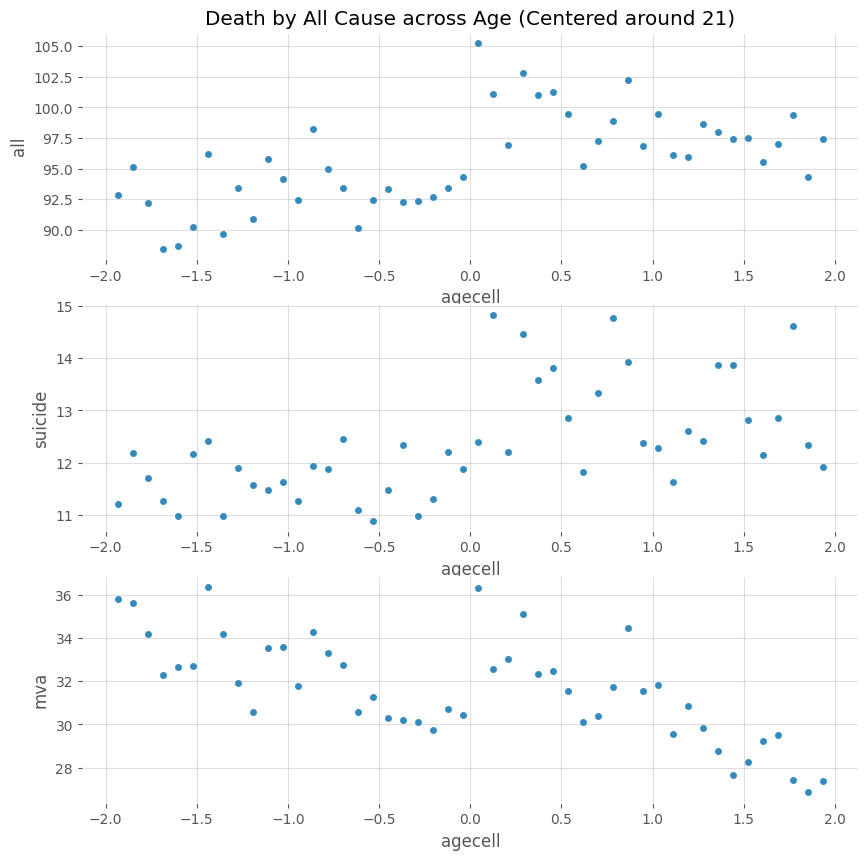

In [34]:
plt.figure(figsize = [10, 10]
          )

ax =\
(
    plt
    .subplot(3, 1, 1) # 3 rows 1 column
)

(
    alcohol
    .plot
    .scatter(x = "agecell",
             y = "all",
             ax = ax)    
)

plt.title("Death by All Cause across Age (Centered around 21)")

# Suicide

ax = plt.subplot(3, 1, 2)

(
    alcohol
    .plot
    .scatter(x = "agecell",
             y = "suicide",
             ax = ax)
)

# Car Accidents

ax = plt.subplot(3, 1, 3)

(
    alcohol
    .plot
    .scatter(x = "agecell",
             y = "mva",
             ax = ax)
)

### MODEL for Regression Discontinuity

> Assumption of RDD

$$ \lim_{r \to c^-} E[Y_{ti} | R_i = r] = \lim_{r \to c^+} E[Y_{ti} | R_i = r]$$

> Regression Specification for RD

$$ y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{l}\{r_i > c\} + \beta_3 \mathcal{l}\{r_i>c\} r_i $$

> Because of the above model specification for regression discontinuity, we should use `weigthed least squares.`

In [35]:
df_for_RDD =\
(
    alcohol
    .assign(threshold = 
             (alcohol["agecell"] > 0)
             .astype(int)
           )
)

In [36]:
df_for_RDD.columns

Index(['agecell', 'all', 'allfitted', 'internal', 'internalfitted', 'external',
       'externalfitted', 'alcohol', 'alcoholfitted', 'homicide',
       'homicidefitted', 'suicide', 'suicidefitted', 'mva', 'mvafitted',
       'drugs', 'drugsfitted', 'externalother', 'externalotherfitted',
       'threshold'],
      dtype='object')

In [37]:
import statsmodels.formula.api as smf

In [38]:
rdd_model =\
(
    smf
    .wls(formula = "all ~ agecell * threshold",
         data = df_for_RDD)
    .fit()
)

In [39]:
print(rdd_model
      .summary()
      .tables[1]
     )

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            93.6184      0.932    100.399      0.000      91.739      95.498
agecell               0.8270      0.819      1.010      0.318      -0.823       2.477
threshold             7.6627      1.319      5.811      0.000       5.005      10.320
agecell:threshold    -3.6034      1.158     -3.111      0.003      -5.937      -1.269


> Learn How to Learn

In [40]:
dir(rdd_model)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalu

In [41]:
# help(rdd_model.fittedvalues)

### Visualize the Model

Text(0.5, 1.0, "Let's see the Regression Discontinuity")

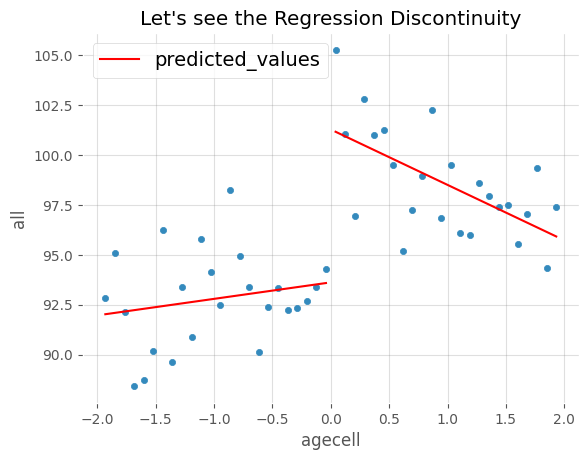

In [42]:
ax =\
(
    alcohol
    .plot
    .scatter(x = "agecell",
             y = "all")
)

(
    alcohol
    .assign(predicted_values = rdd_model.fittedvalues)
    .plot(x = "agecell",
          y = "predicted_values",
          ax = ax,
          color = "red")
)

plt.title("Let's see the Regression Discontinuity")

### In the field, you should pay attention to data storytelling.

In [43]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


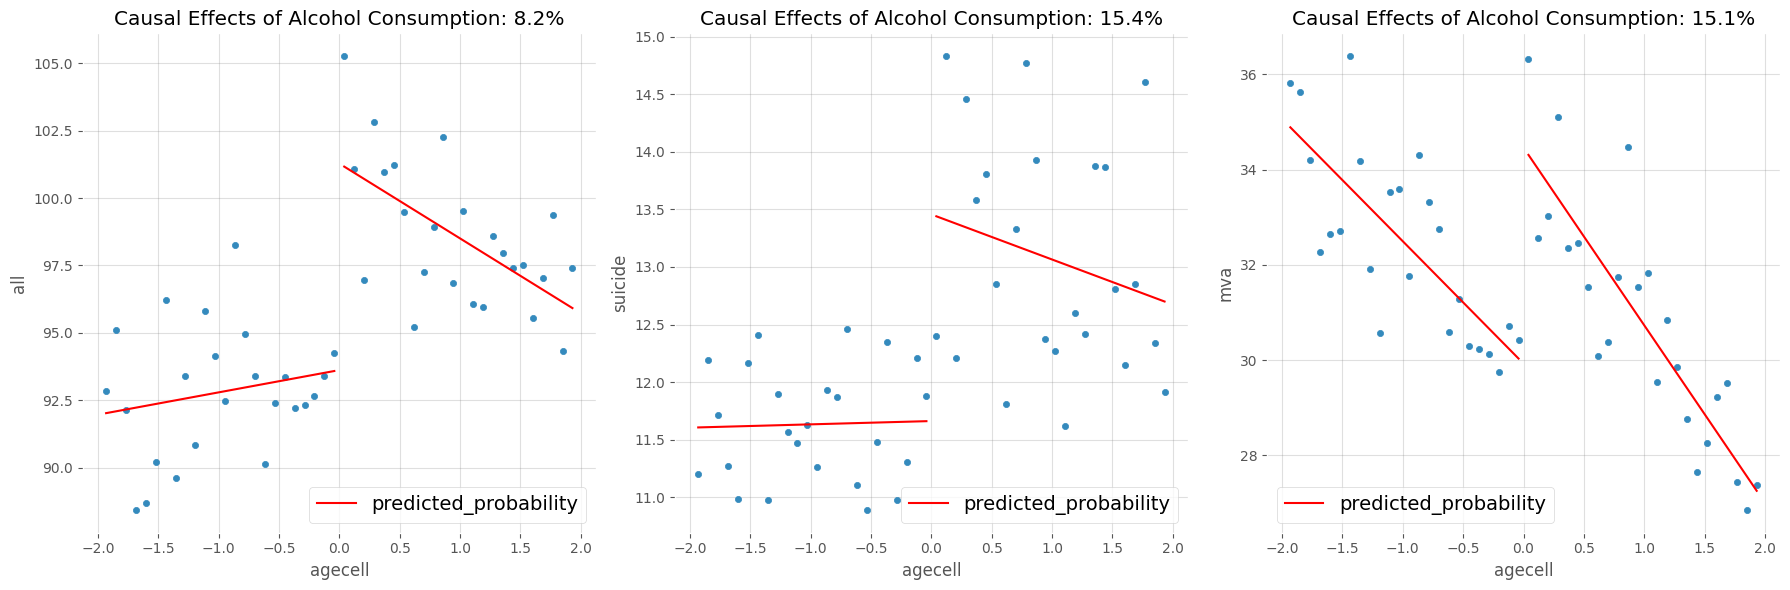

In [44]:
plt.figure(figsize = [18, 6]
          )

# for your elegant coding

for p, cause in enumerate(["all", "suicide", "mva"], 1):

    ax = plt.subplot(1, 3, p)

    alcohol \
        .plot \
        .scatter(x = "agecell",
                 y = cause,
                 ax = ax)

    rdd_models =\
    (
        smf
        .wls(formula = f"{cause} ~ agecell * threshold",
             data = df_for_RDD)
        .fit()
    )

    # team, make sure to input this in your report

    size_of_causal_effects =\
    (
        100
        *
        (
         (rdd_models.params["threshold"] + rdd_models.params["Intercept"])
          /
          rdd_models.params["Intercept"] - 1
        )
    )

    (
        alcohol
        .assign(predicted_probability = rdd_models.fittedvalues)
        .plot(x = "agecell",
              y = "predicted_probability",
              ax = ax,
              color = "red")
    )

    plt.title(f"Causal Effects of Alcohol Consumption: {np.round(size_of_causal_effects, 1)}%")

plt.tight_layout()

### Pro-tips [`Best Practice`]: In the field, please use `kernel` weighting

> The condition of the kernel weighting follows:

$$ K(R, c, h) = \mathcal(l)\{|R-c| \leq h\} \times \bigg(1 - \frac{|R-c|}{h}\bigg)  $$

    This function returns values based on a triangular kernel:

- Maximum value at R = c.

- Linearly decreases as R moves away from c.

- Becomes zero when the distance exceeds the bandwidth h.

In [45]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

- R - c: Computes the distance of each element in R from the center c.

- np.abs(R - c): Takes the absolute value of those distances.

- <= h: Checks whether each value is within the bandwidth h.

> This results in a Boolean array: True if the point is within the window, False otherwise.

- .astype(float): Converts True ‚Üí 1.0 and False ‚Üí 0.0.

> Purpose: This creates a window around c of width 2h, setting values to 1 inside the window and 0 outside.

- np.abs(R - c) / h: Normalizes the distance from the center c over the bandwidth.

- 1 - ...: Creates a triangular shape ‚Äî maximum value 1 at the center (R = c), linearly decreasing to 0 at the edges (|R - c| = h).

- indicator * ...: Ensures that any values outside the bandwidth (i.e., where indicator = 0) are forced to zero.

Text(0.5, 1.0, 'Kernel Weights by Age')

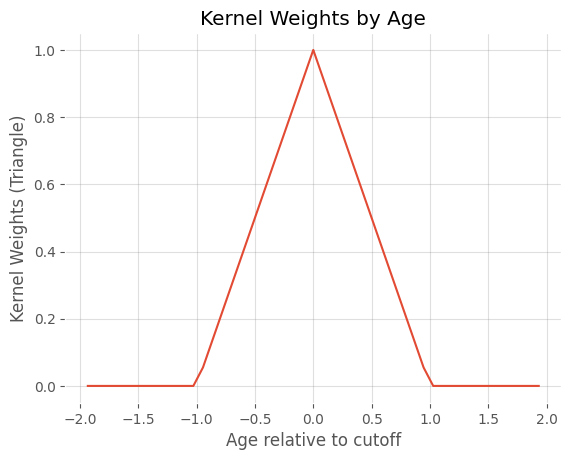

In [46]:
# Let's run the sanity check if the function gives correct weights

plt.plot(alcohol["agecell"],
         kernel(alcohol["agecell"], c = 0, h =1)
        )

plt.xlabel("Age relative to cutoff")
plt.ylabel("Kernel Weights (Triangle)")

plt.title("Kernel Weights by Age")

In [47]:
rdd_model_correcting_biases =\
(
    smf
    .wls(formula = "all ~ agecell * threshold",
         data = df_for_RDD,
         weights = kernel(alcohol["agecell"], c = 0, h =1)
        )
    .fit()
)

In [48]:
print(rdd_model_correcting_biases
      .summary()
      .tables[1]
     )

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            93.2002      0.731    127.429      0.000      91.726      94.674
agecell               0.4109      1.789      0.230      0.819      -3.196       4.017
threshold             9.7004      1.034      9.378      0.000       7.616      11.785
agecell:threshold    -7.1759      2.531     -2.835      0.007     -12.276      -2.075


### Advantages:

* Causal estimates are less sensitive to unobserved confounders.
<br>

* Suitable for non-experimental settings with clear threshold rules.

### Disadvantages:

* Limited to cases with clear thresholds.
<br>

* Results may not be generalizable beyond the threshold.
<br>

* Sensitive to bandwidth choice and functional form assumptions.

### Ultimate Reports of RDD: Team, make sure to `adjust your causal effects with kernel weights`

In [49]:
kernel_weights_for_RDD =\
(
    kernel(alcohol["agecell"], 
           c = 0, 
           h = 1)
)

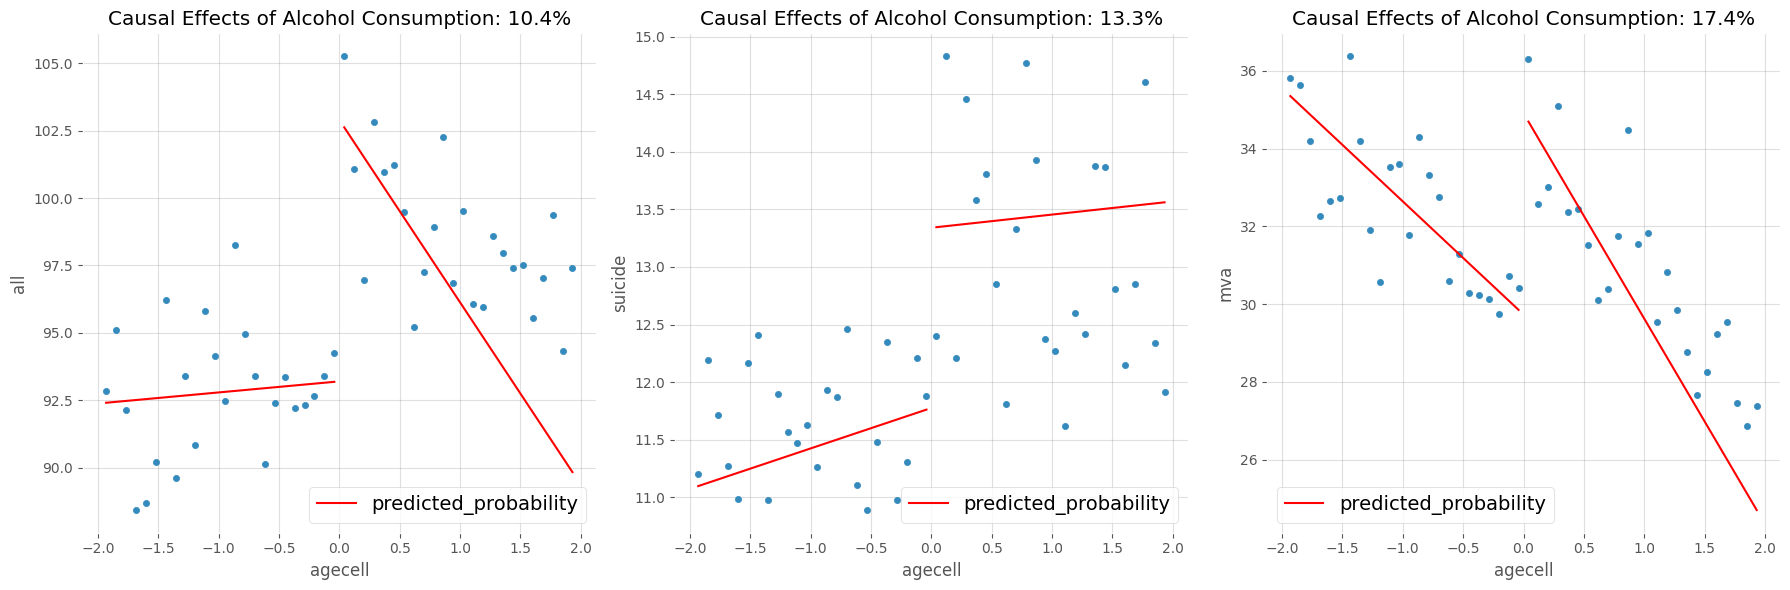

In [50]:
plt.figure(figsize = [18, 6]
          )

# for your elegant coding

for p, cause in enumerate(["all", "suicide", "mva"], 1):

    ax = plt.subplot(1, 3, p)

    alcohol \
        .plot \
        .scatter(x = "agecell",
                 y = cause,
                 ax = ax)

    rdd_models =\
    (
        smf
        .wls(formula = f"{cause} ~ agecell * threshold",
             data = df_for_RDD,
             weights = kernel_weights_for_RDD) # team, make sure to use Kernel weights to adjust the causal effects
        .fit()
    )

    # team, make sure to input this in your report

    size_of_causal_effects =\
    (
        100
        *
        (
         (rdd_models.params["threshold"] + rdd_models.params["Intercept"])
          /
          rdd_models.params["Intercept"] - 1
        )
    )

    (
        alcohol
        .assign(predicted_probability = rdd_models.fittedvalues)
        .plot(x = "agecell",
              y = "predicted_probability",
              ax = ax,
              color = "red")
    )

    plt.title(f"Causal Effects of Alcohol Consumption: {np.round(size_of_causal_effects, 1)}%")

plt.tight_layout()

## <a id = "p3">3.</a>  <font color = "green"> What We Learned & What's Next </font>  [back to table of contents](#top)

    YES! It is always a good idea to reflect on what you've learned and put it into your own words. 

    > Learning Pointers 1. 

    > Learning Pointers 2.

    > Learning Pointers 3.

> `Thank you for working with the script, Team üëç`